<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [ ]:
!wget --header="Host: doc-0o-bk-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_nso6dcn1mbidkt5qr539a2jiefc09pqv_nonce=iak2ig7rpq664" --header="Connection: keep-alive" "https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/nss2f5s2soorprev6d4t4qp3n5ekp9nh/evl2j2j4t5hronicnhsbdlsblnbl9qk3/1622116650000/06629147635963609455/13017565264516993811/1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV?e=download&authuser=0&nonce=iak2ig7rpq664&user=13017565264516993811&hash=fvl5s6dohfnqle6k8q3koe9jr2mhe6jr" -c -O 'storage_sample_stage4.h5'

--2021-06-12 16:01:49--  https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/nss2f5s2soorprev6d4t4qp3n5ekp9nh/evl2j2j4t5hronicnhsbdlsblnbl9qk3/1622116650000/06629147635963609455/13017565264516993811/1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV?e=download&authuser=0&nonce=iak2ig7rpq664&user=13017565264516993811&hash=fvl5s6dohfnqle6k8q3koe9jr2mhe6jr
Resolving doc-0o-bk-docs.googleusercontent.com (doc-0o-bk-docs.googleusercontent.com)... 64.233.170.132, 2607:f8b0:400c:c0d::84
Connecting to doc-0o-bk-docs.googleusercontent.com (doc-0o-bk-docs.googleusercontent.com)|64.233.170.132|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2021-06-12 16:01:49 ERROR 403: Forbidden.



In [ ]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [ ]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [ ]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9063252121775113 test Score 0.8745605278006858
Estimators =  50 Train Score 0.9205725512208812 test Score 0.9125653355634538
Estimators =  100 Train Score 0.9238690848446947 test Score 0.9141199714153599
Estimators =  250 Train Score 0.9239789348046863 test Score 0.9188007232664732
Estimators =  450 Train Score 0.9237190618658074 test Score 0.9161507685828595


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

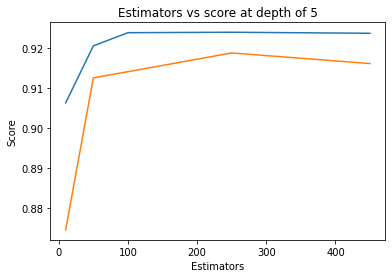

In [ ]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8916120853581238 test Score 0.8687934859875491
depth =  9 Train Score 0.9572226298198419 test Score 0.9222953031452904
depth =  11 Train Score 0.9623451340902863 test Score 0.9252318758281279
depth =  15 Train Score 0.9634267621927706 test Score 0.9231288356496615
depth =  20 Train Score 0.9631629153051491 test Score 0.9235051024711141
depth =  35 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  50 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  70 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  130 Train Score 0.9634333127085721 test Score 0.9235601652753184


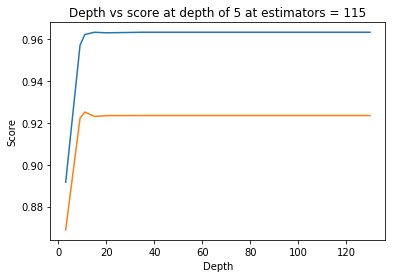

In [ ]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96225043 0.96215493 0.96057081 0.96194015 0.96330005]
mean train scores [0.96294922 0.96266735 0.96115674 0.96263457 0.96430539]


In [ ]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [ ]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9652533106548414
Test f1 score 0.9241678239279553


In [8]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


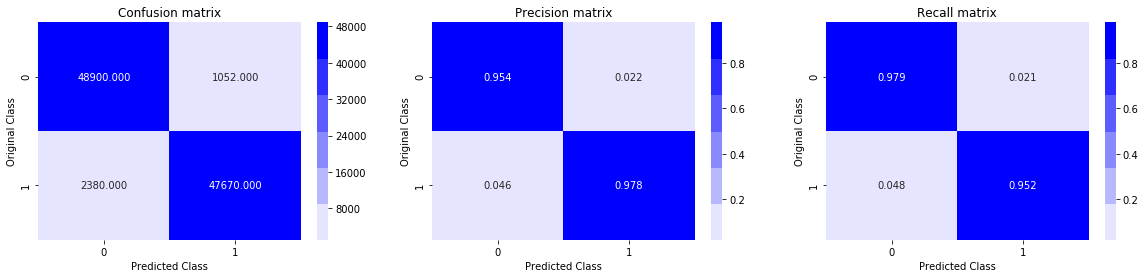

Test confusion_matrix


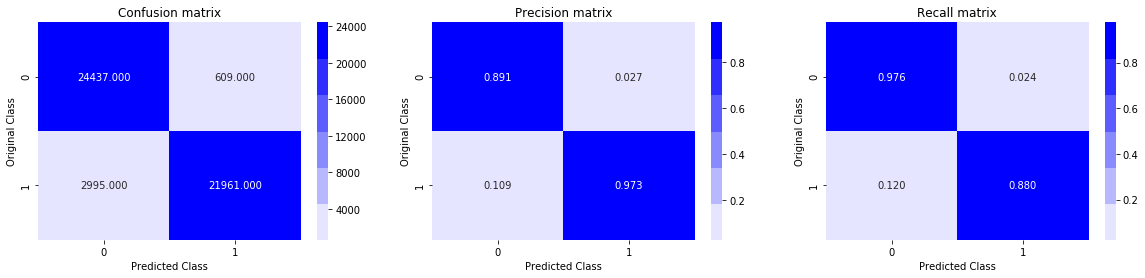

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

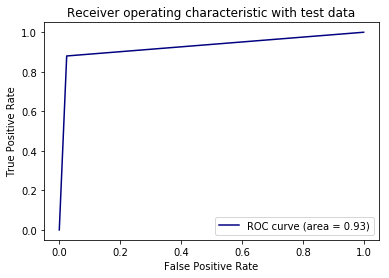

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

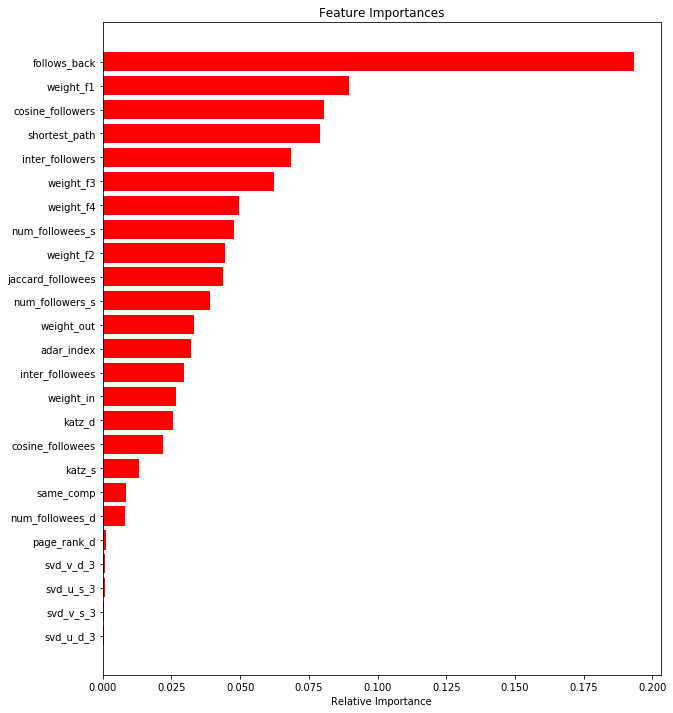

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('/content/drive/MyDrive/Facebook/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/MyDrive/Facebook/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

# Preferential Attachment

Preferential paramater can be obtained by multiplying number of nodes of source and destination

In [5]:
train_graph=nx.read_edgelist('/content/drive/MyDrive/Facebook/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

DiGraph with 1780722 nodes and 7550015 edges


In [6]:
#Finding number of followers of destination node in training dataset
num_followers_d=[]
for i,row in df_final_train.iterrows():
  try:
      s1=set(train_graph.predecessors(row['destination_node']))
  except:
      s1 = set()
  num_followers_d.append(len(s1))

  

Preferential attachment of followers and followees for Train 




In [15]:
num_followers_d=np.array(num_followers_d)
num_followees_d=np.array(df_final_train['num_followees_d'])
num_followers_s=np.array(df_final_train['num_followers_s'])
num_followees_s=np.array(df_final_train['num_followees_s'])
df_final_train['preferential_followers']=num_followers_s*num_followers_d
df_final_train['preferntial_followees']=num_followees_s*num_followees_d

In [17]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers,preferntial_followees
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,1.043044e-05,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,1.068946e-06,1.192357e-12,2.279485e-12,3.580837e-12,-7.216133e-13,3.925975e-13,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,36,120
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,0,1,2,0.102598,0.127000,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,7.051088e-13,-8.250564e-11,-1.717702e-10,3.705016e-02,1.032392e-11,7.207497e-10,1.644399e-12,-2.047752e-10,-3.943936e-10,8.617541e-02,2.399540e-11,1.738682e-09,2.685878e-13,-3.316849e-11,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,8836,8662
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,0,1,2,0.185695,0.154303,0.339999,0.028653,0.525694,0.494302,6.211019e-07,5.179801e-07,0.000885,0.000855,7.730764e-114,4.067322e-114,2.681298e-113,2.199205e-113,-4.900734e-18,1.096831e-18,-6.816555e-19,-2.226453e-18,6.710556e-19,-8.161336e-19,-2.606312e-18,6.392474e-19,-4.245830e-19,-1.315747e-18,3.849627e-19,-1.131971e-18,-1.510265e-18,1.454979e-19,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,784,902
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,0,0,0.000000,0,1,6,0.288675,0.408248,0.696923,0.117851,0.985599,1.105172,2.998153e-07,1.704245e-06,0.000739,0.000773,5.443738e-17,4.139999e-16,2.413250e-14,6.688064e-15,-9.965436e-12,4.077137e-13,5.083778e-10,1.985267e-14,2.471968e-12,1.004354e-15,-2.629029e-13,1.428940e-11,9.146784e-11,8.590132e-12,2.406658e-10,7.638106e-15,-2.170899e-13,5.206150e-13,6.058498e-11,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,121,35
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,0,0,0.000000,0,0,-1,1.000000,0.301511,1.301511,0.301511,2.301511,1.603023,4.349180e-07,2.089590e-07,0.000751,0.000735,3.887821e-16,4.721269e-16,7.552255e-16,2.734009e-18,-3.408943e-13,1.125207e-13,3.190883e-07,8.550846e-14,1.405351e-13,7.172313e-15,-2.550169e-13,2.424636e-13,2.436301e-07,3.679960e-14,1.348520e-13,8.710393e-15,-4.795514e-13,1.521297e-13,1.197283e-07,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,33


Preferential attachment of followers and followees for Test 


In [19]:
num_followers_d=[]
for i,row in df_final_test.iterrows():
  try:
      s1=set(train_graph.predecessors(row['destination_node']))
  except:
      s1 = set()
  num_followers_d.append(len(s1))

  

In [22]:
#Calculating Preferential attachment for Test set
num_followers_d=np.array(num_followers_d)
num_followees_d=np.array(df_final_test['num_followees_d'])
num_followers_s=np.array(df_final_test['num_followers_s'])
num_followees_s=np.array(df_final_test['num_followees_s'])
df_final_test['preferential_followers']=num_followers_s*num_followers_d
df_final_test['preferntial_followees']=num_followees_s*num_followees_d

In [23]:
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers,preferntial_followees
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,0.000002,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,-9.987979e-12,2.283676e-13,1.439968e-10,6.136162e-13,4.188171e-13,5.983361e-15,-1.026186e-11,5.316372e-13,5.843225e-10,1.166047e-13,2.253356e-11,3.220367e-15,-2.148852e-13,1.883148e-13,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,196,54
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,0,0,0.000000,1,1,7,0.235702,0.707107,0.942809,0.166667,1.178511,1.649916,2.172064e-07,0.000001,0.000739,0.000801,1.702625e-19,2.706300e-15,2.522357e-16,5.277458e-15,-2.079151e-15,7.009864e-16,6.970710e-10,9.561769e-15,1.728794e-15,3.122935e-18,-1.960277e-11,2.861530e-11,1.939773e-08,1.907382e-12,3.797410e-11,4.992848e-14,-4.054309e-13,2.895682e-13,2.545382e-10,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,289,19
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,0,0,0.000000,0,1,5,0.301511,0.242536,0.544047,0.073127,0.845558,0.786583,1.853369e-06,0.000002,0.000789,0.000770,9.426796e-14,4.116616e-16,2.253244e-15,2.079387e-15,-1.782290e-11,2.389627e-11,1.443050e-06,2.358030e-12,2.689638e-12,1.739178e-12,-1.863934e-13,1.806783e-13,2.544597e-07,1.693295e-13,2.712748e-13,7.594641e-15,-4.148103e-13,4.618813e-12,1.122150e-05,1.778927e-12,2.740535e-13,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,100,144
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,0,0,0.000000,0,1,3,0.162221,0.301511,0.463733,0.048912,0.625954,0.765244,7.000791e-07,0.000002,0.000778,0.000884,9.876114e-14,1.039593e-13,1.511694e-14,3.478438e-14,-4.491246e-11,9.917404e-13,7.891250e-06,9.458624e-12,2.715848e-11,1.822074e-12,-1.070733e-10,2.888035e-12,2.070703e-05,7.229355e-12,3.563659e-11,1.917977e-12,-8.942488e-12,5.535630e-12,5.223676e-06,7.917166e-13,4.020707e-12,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,1369,340
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,4,7,6.136433,0,1,2,0.188982,0.250000,0.438982,0.047246,0.627964,0.688982,7.103008e-07,0.000001,0.000779,0.000840,1.557332e-15,1.096037e-14,5.180869e-15,1.296135e-14,-9.778448e-13,5.724610e-13,4.951883e-06,1.396834e-12,2.153249e-11,2.873183e-14,-2.275780e-11,1.007615e-12,2.517628e-06,1.394103e-10,2.961969e-11,2.022115e-13,-3.804979e-12,1.593011e-13,1.035016e-06,1.361574e-13,1.154623e-12,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,729,405


# SVD dot product Feature

Dot product of SVD is obtained as dot product of u vectors of source and destination and dot product of v vectors of source and destination 

Finding SVD dot of Training set

In [26]:
df_final_train['svd_dot_u']=(df_final_train['svd_u_s_1']*df_final_train['svd_u_d_1'])+\
                            (df_final_train['svd_u_s_2']*df_final_train['svd_u_d_2'])+\
                            (df_final_train['svd_u_s_3']*df_final_train['svd_u_d_3'])+\
                            (df_final_train['svd_u_s_4']*df_final_train['svd_u_d_4'])+\
                            (df_final_train['svd_u_s_5']*df_final_train['svd_u_d_5'])+\
                            (df_final_train['svd_u_s_6']*df_final_train['svd_u_d_6'])

df_final_train['svd_dot_v']=(df_final_train['svd_v_s_1']*df_final_train['svd_v_d_1'])+\
                            (df_final_train['svd_v_s_2']*df_final_train['svd_v_d_2'])+\
                            (df_final_train['svd_v_s_3']*df_final_train['svd_v_d_3'])+\
                            (df_final_train['svd_v_s_4']*df_final_train['svd_v_d_4'])+\
                            (df_final_train['svd_v_s_5']*df_final_train['svd_v_d_5'])+\
                            (df_final_train['svd_v_s_6']*df_final_train['svd_v_d_6'])                  

SVD dot for test set

In [28]:
df_final_test['svd_dot_u']=(df_final_test['svd_u_s_1']*df_final_test['svd_u_d_1'])+\
                            (df_final_test['svd_u_s_2']*df_final_test['svd_u_d_2'])+\
                            (df_final_test['svd_u_s_3']*df_final_test['svd_u_d_3'])+\
                            (df_final_test['svd_u_s_4']*df_final_test['svd_u_d_4'])+\
                            (df_final_test['svd_u_s_5']*df_final_test['svd_u_d_5'])+\
                            (df_final_test['svd_u_s_6']*df_final_test['svd_u_d_6'])

df_final_test['svd_dot_v']=(df_final_test['svd_v_s_1']*df_final_test['svd_v_d_1'])+\
                            (df_final_test['svd_v_s_2']*df_final_test['svd_v_d_2'])+\
                            (df_final_test['svd_v_s_3']*df_final_test['svd_v_d_3'])+\
                            (df_final_test['svd_v_s_4']*df_final_test['svd_v_d_4'])+\
                            (df_final_test['svd_v_s_5']*df_final_test['svd_v_d_5'])+\
                            (df_final_test['svd_v_s_6']*df_final_test['svd_v_d_6'])                  

In [31]:
hdf = HDFStore('/content/drive/MyDrive/storage_sample_stage5.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

In [5]:
df_final_train = read_hdf('/content/drive/MyDrive/storage_sample_stage5.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/MyDrive/storage_sample_stage5.h5', 'test_df',mode='r')

In [6]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [7]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
clf = XGBClassifier()
params = {"n_estimators":sp_randint(105,125),"max_depth": sp_randint(10,15)}
model = RandomizedSearchCV(clf, param_distributions=params,
                                   n_iter=5,cv=5,scoring='f1',random_state=25,verbose=20,n_jobs=-1)
model.fit(df_final_train,y_train)
print('mean test scores',model.cv_results_['mean_test_score'])
print('mean train scores',model.cv_results_['mean_train_score'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 21

mean test scores [0.98008314 0.98012406 0.97971437 0.98010108 0.9800929 ]


KeyError: ignored

In [ ]:
model.cv_results_


In [17]:
print(model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=None, n_estimators=123, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [18]:
clf=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=None, n_estimators=123, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [19]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [20]:
 
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9999400563470339
Test f1 score 0.9271523178807948


Train confusion_matrix


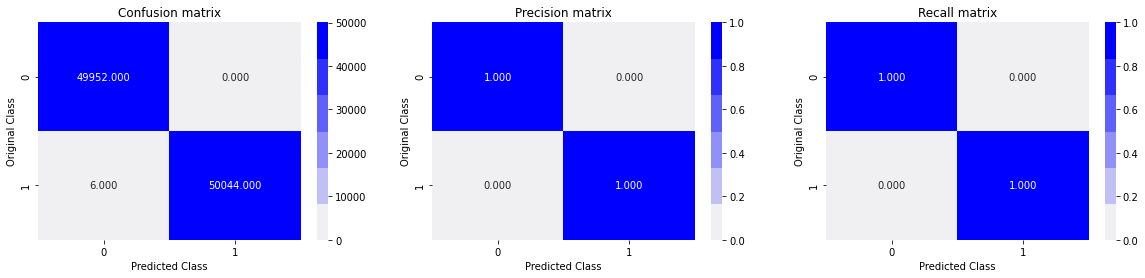

Test confusion_matrix


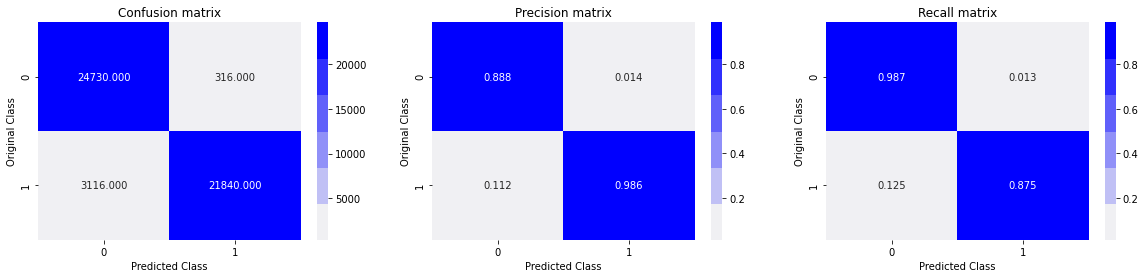

In [21]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

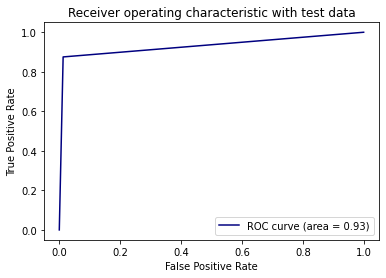

In [22]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

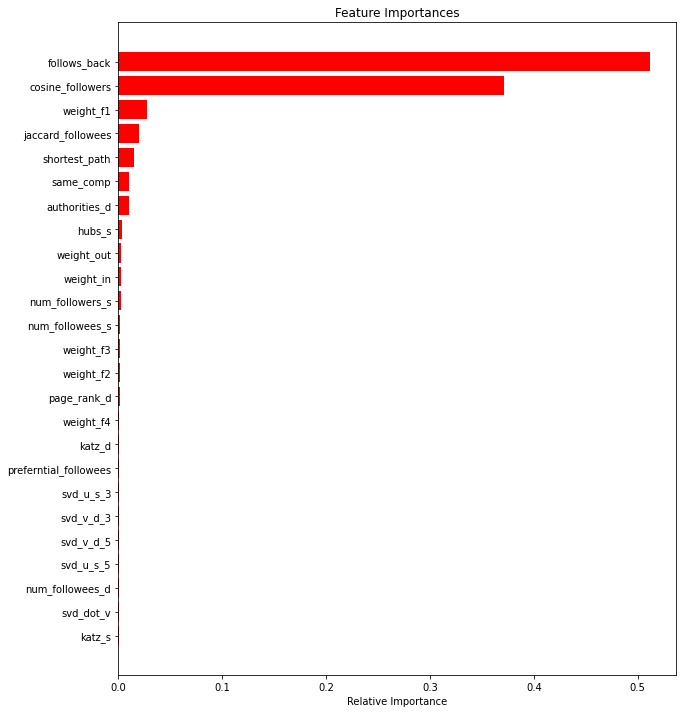

In [23]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Procedure

---

1)First Exploratory Data Analysis is done  both source node and destination node and Bad Links are generated

2)Featurization is done on training and test data.
Features which are added are Jacard distance, cosine distance, page ranking, Hits score, Kartz centrality,Adar index, same community, shortest path, num of followers and followees, following back,weight of edges, SVD features, svd dot and Preferential attachmet

3)Model is trained with Random Forest and XGboost and parameters are hypertuned

4)Model is trained with best parameters

5)F1 score , AUC score is computed

6)Confusion matrix, precision matrix, recall matrix and ROC curve is plotted.

7)Top 25 important features are find out.

In [24]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "n_estimators", "max_depth", "Train F1 Score","Test F1 Score"]
x.add_row(['Random Forest','121','14','0.965','0.924'])
x.add_row(['XGBoost','123','14','0.999','0.927'])
print(x)

+---------------+--------------+-----------+----------------+---------------+
|     Model     | n_estimators | max_depth | Train F1 Score | Test F1 Score |
+---------------+--------------+-----------+----------------+---------------+
| Random Forest |     121      |     14    |     0.965      |     0.924     |
|    XGBoost    |     123      |     14    |     0.999      |     0.927     |
+---------------+--------------+-----------+----------------+---------------+
